In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import t
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


In [2]:
training_set_complete = pd.read_csv("data/training_set_online_shoppers_intention.csv")
missing_values = training_set_complete[training_set_complete['ExitRates'].isna()]
training_set = training_set_complete[training_set_complete['ExitRates'].isna()==False]

In [3]:
X = training_set.drop(columns=['ExitRates','Revenue','Unnamed: 0'])
y = training_set['ExitRates']
X = pd.get_dummies(X, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType'], drop_first=True)
X['Weekend'] = np.where(training_set['Weekend']=='True',1,0)

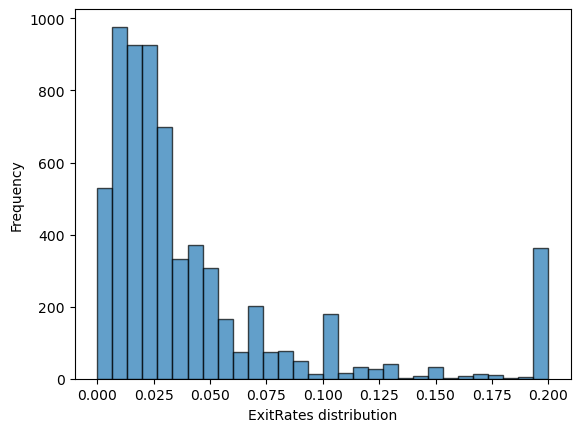

In [4]:
# Plotta l'istogramma
plot = plt.hist(np.array(y), bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

Qui ti ho plottato la distribuzione di y con una trasformazione y=y^(1/3). La distribuzione è bella: sembra quasi normale! Il problema è che quando la uso ho delle performance davvero peggiori :(. Il problema è che proprio a livello di residual plot ci sono delle cose che non vanno, quindi secondo me non è il massimo. Di tutte le distribuzioni che ho provato questa mi sembra la migliore: quella logaritmica (con +1 per evitare problemi con lo zero) rimaneva quasi uguale.

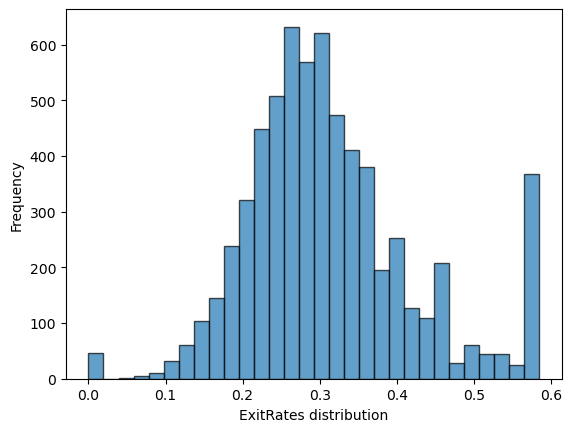

In [5]:
y_transformed = np.power(np.array(y),1/3)
#y_transformed = np.log(np.array(y)+1)
plot = plt.hist(y_transformed, bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)
#y = pd.Series(y_transformed)

## Linear and polynomial regression

In [6]:
test_size = 0.2
seed = 50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

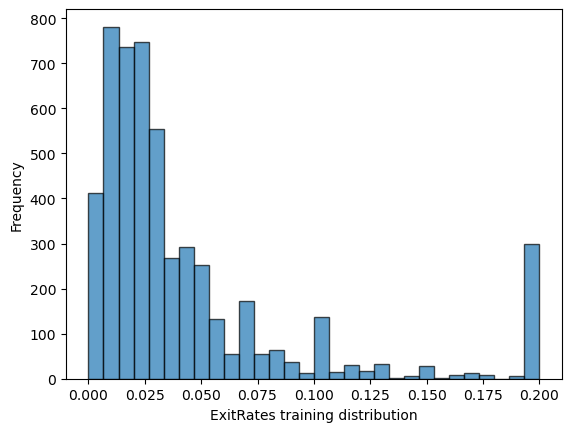

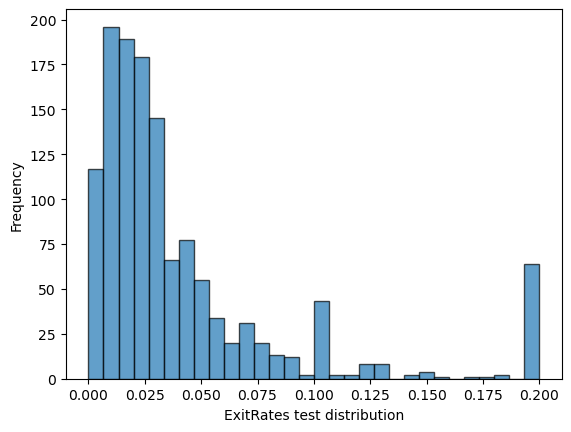

In [7]:
plot = plt.hist(y_train, bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates training distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

plot = plt.hist(y_test, bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates test distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

mse_train = mean_squared_error(y_train, lin_reg.predict(X_train))
r2_train = r2_score(y_train, lin_reg.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)
print("Mean Squared Error:", mse_test)
print("R-squared:", r2_test)

LinearRegression()

Mean Squared Error: 0.0003183420830046056
R-squared: 0.8656530663097467
Mean Squared Error: 0.0003140097299691822
R-squared: 0.8515022729738447


Now we look at the coefficients:

In [9]:
# Create a dictionary to store feature-coefficient associations
feature_coefficients = {}

# Extract and store the coefficient for each feature
for feature_name, coefficient in zip(X.columns, lin_reg.coef_):
    feature_coefficients[feature_name] = coefficient

# Print the feature-coefficient associations
for feature, coefficient in feature_coefficients.items():
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: Administrative, Coefficient: -0.0008455509159685309
Feature: Administrative_Duration, Coefficient: -3.4946233341442265e-06
Feature: Informational, Coefficient: 9.618659747112884e-05
Feature: Informational_Duration, Coefficient: -5.550071299749524e-07
Feature: ProductRelated, Coefficient: -0.0001225655206984125
Feature: ProductRelated_Duration, Coefficient: 4.5209121337860814e-07
Feature: BounceRates, Coefficient: 0.8589994084605495
Feature: PageValues, Coefficient: -0.00013181963618622006
Feature: SpecialDay, Coefficient: 0.007062733886181782
Feature: Weekend, Coefficient: -1.4432899320127035e-15
Feature: Month_Dec, Coefficient: 0.002378655890006076
Feature: Month_Feb, Coefficient: 0.002636756739794896
Feature: Month_Jul, Coefficient: 0.003687042126779603
Feature: Month_June, Coefficient: 0.007449141475192286
Feature: Month_Mar, Coefficient: 0.001329815667196619
Feature: Month_May, Coefficient: 0.001027208608040675
Feature: Month_Nov, Coefficient: 0.0016425761127551453
Feature

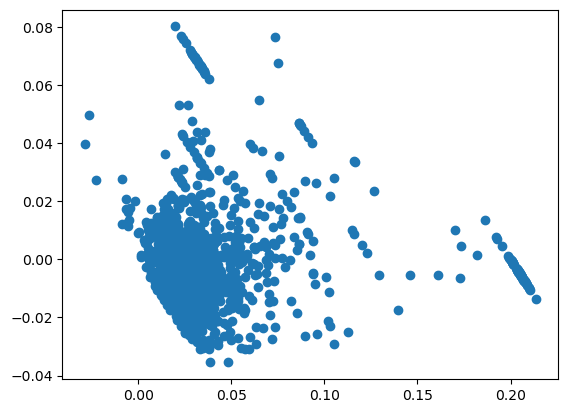

In [10]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

Now we check if we may have a better model with polynomial features:

In [11]:
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,3))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train, y_train)
best_polynomial_model = cv.best_estimator_
print("Best Hyperparameters:", cv.best_params_)
print("Best R-squared Score:", cv.best_score_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2]},
             scoring=make_scorer(r2_score))

Best Hyperparameters: {'poly__degree': 1}
Best R-squared Score: 0.8611578738936222


So if we consider all the variables the best model still be the one with grade 1.

## Ridge regression
We saw that the best degree is one. We want to see if we can improve it with ridge regression:

In [12]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('ridge', Ridge())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ridge__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['ridge'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 10.0
Best coefficients: [-2.77871503e-03 -5.80454598e-04  1.17639694e-04 -7.01646983e-05
 -5.30703867e-03  7.29088245e-04  4.15828329e-02 -2.37895985e-03
  1.38613227e-03  0.00000000e+00  8.00011771e-04  3.12799931e-04
  6.66371666e-04  1.12612879e-03  4.52508986e-04  4.26598312e-04
  6.83555612e-04 -2.31986197e-05  9.90920904e-06  9.88461597e-04
 -9.67219141e-04  3.05069969e-04 -2.46002820e-05 -4.39073702e-04
 -5.95093542e-05 -4.19010565e-04  6.00287891e-05  3.54639614e-04
  2.54960496e-04 -7.29689960e-05 -1.31061929e-04  2.06396901e-04
  7.37845311e-05 -3.23650687e-04 -2.46002820e-05 -1.26158335e-04
 -6.66544429e-04 -2.09396970e-04  1.35513199e-04 -3.65844437e-05
  7.68399535e-06 -3.78743210e-04 -5.74489521e-04 -4.46108781e-04
  3.63484814e-04 -1.72232939e-03  3.47848049e-04 -1.01032415e-03
 -7.21129992e-05  4.78805658e-05 -3.50054819e-05 -3.22921132e-04
 -1.27926891e-04 -3.74059914e-04 -5.82963190e-05  4.42348812e-04
  5.61298073e-04 -2.55893934e-04 -6.46008811e-05 -3.69

In [13]:
best_model_ridge = grid_search.best_estimator_
y_pred = best_model_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model_ridge.named_steps['ridge'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best alpha: 10.0
Best coefficients: [-2.77871503e-03 -5.80454598e-04  1.17639694e-04 -7.01646983e-05
 -5.30703867e-03  7.29088245e-04  4.15828329e-02 -2.37895985e-03
  1.38613227e-03  0.00000000e+00  8.00011771e-04  3.12799931e-04
  6.66371666e-04  1.12612879e-03  4.52508986e-04  4.26598312e-04
  6.83555612e-04 -2.31986197e-05  9.90920904e-06  9.88461597e-04
 -9.67219141e-04  3.05069969e-04 -2.46002820e-05 -4.39073702e-04
 -5.95093542e-05 -4.19010565e-04  6.00287891e-05  3.54639614e-04
  2.54960496e-04 -7.29689960e-05 -1.31061929e-04  2.06396901e-04
  7.37845311e-05 -3.23650687e-04 -2.46002820e-05 -1.26158335e-04
 -6.66544429e-04 -2.09396970e-04  1.35513199e-04 -3.65844437e-05
  7.68399535e-06 -3.78743210e-04 -5.74489521e-04 -4.46108781e-04
  3.63484814e-04 -1.72232939e-03  3.47848049e-04 -1.01032415e-03
 -7.21129992e-05  4.78805658e-05 -3.50054819e-05 -3.22921132e-04
 -1.27926891e-04 -3.74059914e-04 -5.82963190e-05  4.42348812e-04
  5.61298073e-04 -2.55893934e-04 -6.46008811e-05 -3.69

The $R^2$ decreased wrt the linear model. In this case, it may be correct, because all our coefficients are very small and Ridge regression is more appropriate when we have some high coefficients that we want to shrink to 0.

## Lasso

In [14]:
from sklearn.linear_model import Lasso
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('lasso', Lasso())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['lasso__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['lasso'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 0.01
Best coefficients: [-0.         -0.         -0.         -0.         -0.         -0.
  0.03448456 -0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.          0.        ]


In [15]:
best_model_lasso = grid_search.best_estimator_
y_pred = best_model_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model_lasso.named_steps['lasso'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best alpha: 0.01
Best coefficients: [-0.         -0.         -0.         -0.         -0.         -0.
  0.03448456 -0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.          0.        ]
Mean Squared Error: 0.00045944184144113475
R-squared: 0.782726257681838


In [16]:
coefficients_df = pd.DataFrame({
    #'Feature': X.columns,
    'Ridge Coefficients': best_model_ridge.named_steps['ridge'].coef_,
    'Lasso Coefficients': best_model_lasso.named_steps['lasso'].coef_
})

# Print the entire DataFrame to see the coefficients with the associated variables
coefficients_df

,Ridge Coefficients,Lasso Coefficients
0,-0.002779,-0.0
1,-0.000580,-0.0
2,0.000118,-0.0
3,-0.000070,-0.0
4,-0.005307,-0.0
...,...,...
61,-0.000204,0.0
62,-0.000502,-0.0
63,-0.000093,0.0
64,0.001768,0.0


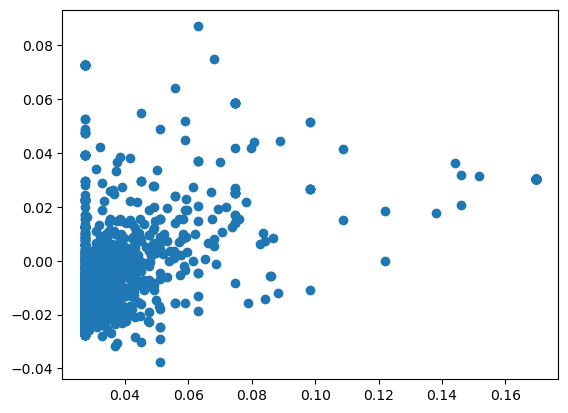

In [17]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

To perform an accurate evaluation of the models we compute the RMSE throug 5-cv. As we can see from the results, the linear regression shows a better score wrt ridge and lasso. 

In [18]:
# Linear Regression
linear_reg_score = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
linear_reg_rmse = np.sqrt(-linear_reg_score.mean())

# Ridge Regression
ridge_reg_score = cross_val_score(best_model_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_reg_rmse = np.sqrt(-ridge_reg_score.mean())

# Lasso Regression
lasso_reg_score = cross_val_score(best_model_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_reg_rmse = np.sqrt(-lasso_reg_score.mean())

# Evaluation
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
rmse_scores = [linear_reg_rmse, ridge_reg_rmse, lasso_reg_rmse]

for model, rmse_score in zip(models, rmse_scores):
    print(f"{model}: RMSE = {rmse_score}")

# Select the best model based on the RMSE score and further analysis


Linear Regression: RMSE = 0.017985282008932305
Ridge Regression: RMSE = 0.017985023531300517
Lasso Regression: RMSE = 0.02209996552302608


## Forward stepwise selection

In [19]:
# Convert back from numpy arrays to data frames
X_all_features = list(np.delete(X.columns.values, [np.where(training_set.columns.values=='Unnamed: 0'),np.where(training_set.columns.values=='ExitRates'),np.where(training_set.columns.values=='Revenue')], axis=None))
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

In [20]:
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator  

from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M0) with 1 features: ['BounceRates']
M0 subset score (3.): 0.833393666895193
............
Best model (M1) with 2 features: ['BounceRates', 'ProductRelated']
M1 subset score (3.): 0.8454651006406788
............
Best model (M2) with 3 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor']
M2 subset score (3.): 0.850641062685367
............
Best model (M3) with 4 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues']
M3 subset score (3.): 0.8537346491486157
............
Best model (M4) with 5 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration']
M4 subset score (3.): 0.8558582491749298
............
Best model (M5) with 6 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2']
M5 subset score (3.): 0.8567737750823842
............
Best model (M6) with 7 features: ['B

............
Best model (M25) with 26 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'VisitorType_Other', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'TrafficType_13', 'Browser_13', 'TrafficType_3', 'Region_7', 'ProductRelated_Duration', 'Region_8', 'TrafficType_12', 'Month_Oct', 'Region_6', 'TrafficType_19', 'Browser_3', 'Month_May', 'Month_Jul', 'OperatingSystems_6', 'TrafficType_16']
M25 subset score (3.): 0.859955018713998
............
Best model (M26) with 27 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'VisitorType_Other', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'TrafficType_13', 'Browser_13', 'TrafficType_3', 'Region_7', 'ProductRelated_Duration', 'Region_8', 'TrafficType_12', 'Month_Oct', 'Region_6', 'TrafficType_19', 'Browser_3', 'Month_

............
Best model (M38) with 39 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'VisitorType_Other', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'TrafficType_13', 'Browser_13', 'TrafficType_3', 'Region_7', 'ProductRelated_Duration', 'Region_8', 'TrafficType_12', 'Month_Oct', 'Region_6', 'TrafficType_19', 'Browser_3', 'Month_May', 'Month_Jul', 'OperatingSystems_6', 'TrafficType_16', 'Region_9', 'Month_Feb', 'Month_Dec', 'Informational', 'Browser_10', 'OperatingSystems_4', 'TrafficType_14', 'TrafficType_10', 'Month_Nov', 'Month_Mar', 'OperatingSystems_8', 'Region_2', 'TrafficType_8']
M38 subset score (3.): 0.8598013033841705
............
Best model (M39) with 40 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'VisitorType_Other', 'TrafficType_4', 'Month_June'

............
Best model (M48) with 49 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'VisitorType_Other', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'TrafficType_13', 'Browser_13', 'TrafficType_3', 'Region_7', 'ProductRelated_Duration', 'Region_8', 'TrafficType_12', 'Month_Oct', 'Region_6', 'TrafficType_19', 'Browser_3', 'Month_May', 'Month_Jul', 'OperatingSystems_6', 'TrafficType_16', 'Region_9', 'Month_Feb', 'Month_Dec', 'Informational', 'Browser_10', 'OperatingSystems_4', 'TrafficType_14', 'TrafficType_10', 'Month_Nov', 'Month_Mar', 'OperatingSystems_8', 'Region_2', 'TrafficType_8', 'Browser_4', 'TrafficType_18', 'Browser_7', 'TrafficType_5', 'Browser_6', 'TrafficType_9', 'Browser_8', 'Region_4', 'Browser_12', 'TrafficType_15']
M48 subset score (3.): 0.8591511943723231
............
Best model (M49) with 50 features: ['BounceRates', 'ProductRelated', 'VisitorType_Re

............
Best model (M57) with 58 features: ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'VisitorType_Other', 'TrafficType_4', 'Month_June', 'OperatingSystems_3', 'TrafficType_13', 'Browser_13', 'TrafficType_3', 'Region_7', 'ProductRelated_Duration', 'Region_8', 'TrafficType_12', 'Month_Oct', 'Region_6', 'TrafficType_19', 'Browser_3', 'Month_May', 'Month_Jul', 'OperatingSystems_6', 'TrafficType_16', 'Region_9', 'Month_Feb', 'Month_Dec', 'Informational', 'Browser_10', 'OperatingSystems_4', 'TrafficType_14', 'TrafficType_10', 'Month_Nov', 'Month_Mar', 'OperatingSystems_8', 'Region_2', 'TrafficType_8', 'Browser_4', 'TrafficType_18', 'Browser_7', 'TrafficType_5', 'Browser_6', 'TrafficType_9', 'Browser_8', 'Region_4', 'Browser_12', 'TrafficType_15', 'TrafficType_7', 'TrafficType_20', 'Browser_5', 'OperatingSystems_7', 'Informational_Duration', 'TrafficType_6', 'Region_3', 'TrafficType_1

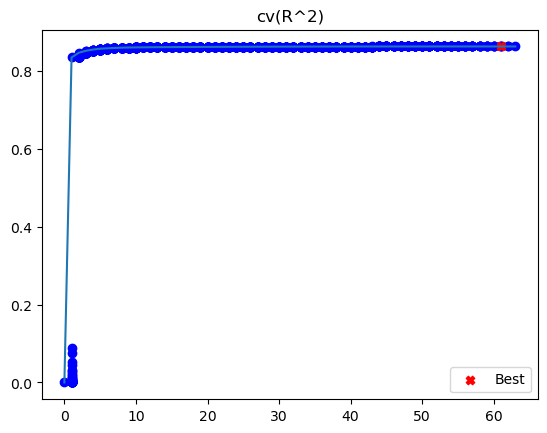

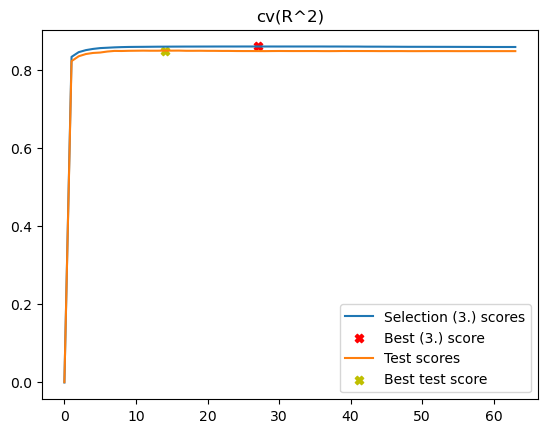

In [21]:
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=90)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator


cv = 10
sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score), cv=cv), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

In [26]:
best_features = ['BounceRates', 'ProductRelated', 'VisitorType_Returning_Visitor', 'PageValues', 'Administrative_Duration', 'TrafficType_2', 'OperatingSystems_2', 'VisitorType_Other', 'TrafficType_4',
                 'Month_June', 'OperatingSystems_3', 'TrafficType_13', 'Browser_13', 'TrafficType_3', 'Region_7', 'ProductRelated_Duration', 'Region_8', 'TrafficType_12', 'Month_Oct', 'Region_6', 'TrafficType_19', 'Browser_3', 'Month_May', 'Month_Jul', 'OperatingSystems_6', 'TrafficType_16', 'Region_9']
X = X[best_features].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

degree = list(range(1,5))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

Best degree:  1 
Val score:  0.8602155840823151
Test score: 0.8481960911213604


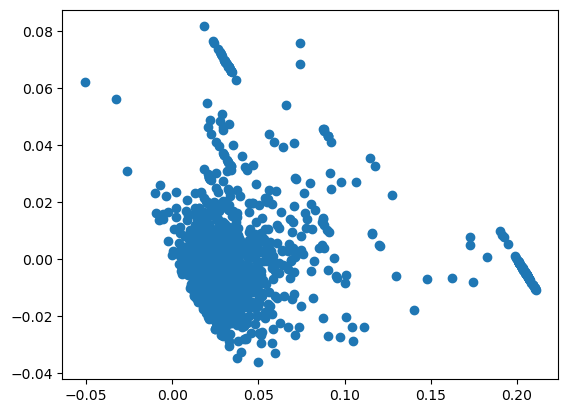

In [27]:
residuals = y_test-y_predict
plt.scatter(y_predict,residuals)
plt.show()